<a href="https://colab.research.google.com/github/JKDS87/Sales-Predictions/blob/main/Sales_Predictions_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Sales

Student: Matthew Malueg

# Load libraries and files

**Loading and Importing**

In [129]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
# Import packages for column transformation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import missingno
pd.set_option('display.max_columns',100)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [131]:
# Load in the data from Google Drive, set the index, and preview first 5 rows
fpath = '/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv'
df = pd.read_csv(fpath)

**Custom Functions**

In [132]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [133]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):

    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [134]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

def plot_coeffs(coeffs, top_n=None, figsize=(4,5),
                intercept=False, intercept_name="intercept",
                annotate=False, ha='left', va='center', size=12,
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

In [135]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

# Initial inspection and cleaning

## Inspect data and drop duplicates

In [136]:
# Examine data for errors, or inconsistency in labeling and categorical data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


In [137]:
df.nunique() / len(df) * 100

Item_Identifier             18.29
Item_Weight                  4.87
Item_Fat_Content             0.06
Item_Visibility             92.46
Item_Type                    0.19
Item_MRP                    69.67
Outlet_Identifier            0.12
Outlet_Establishment_Year    0.11
Outlet_Size                  0.04
Outlet_Location_Type         0.04
Outlet_Type                  0.05
Item_Outlet_Sales           40.98
dtype: float64

In [138]:
# Check for any duplicates
df.duplicated().sum()

0

In [139]:
# Drop Item_Identifier and verify
df = df.drop(columns='Item_Identifier')
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


## Correcting strings

In [140]:
# Inspect 'Outlet_Identifier'
df['Outlet_Identifier'].value_counts()

# The string 'OUT' is extraneous.

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [141]:
# Remove string characters and convert to int
df['Outlet_Identifier'] = df['Outlet_Identifier'].str.replace('OUT', '')#.astype('int')
df['Outlet_Identifier'] = df['Outlet_Identifier'].astype('int')
df['Outlet_Identifier'].value_counts()

27    935
13    932
49    930
46    930
35    930
45    929
18    928
17    926
10    555
19    528
Name: Outlet_Identifier, dtype: int64

In [142]:
# Inspect 'Outlet_Location_Type'
df['Outlet_Location_Type'].value_counts()

# The string 'Tier ' is extraneous.

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [143]:
# Remove string characters and convert to int
df['Outlet_Location_Type'] = df['Outlet_Location_Type'].str.replace('Tier ', '')
df['Outlet_Location_Type'] = df['Outlet_Location_Type'].astype('int')
df['Outlet_Location_Type'].value_counts()

3    3350
2    2785
1    2388
Name: Outlet_Location_Type, dtype: int64

In [144]:
# Inspect 'Item_Fat_Content' for inconsistencies
df['Item_Fat_Content'].value_counts()

# We can consolidate some of these values.

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [145]:
# Replace strings to consolidate values
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat',
                                                         'low fat': 'Low Fat',
                                                         'reg': 'Regular'})
# Inspect 'Item_Fat_Content' to verify change
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [146]:
# Check amount of missing values
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [147]:
# Inspect 'Outlet_Size' for inconsistencies
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [148]:
# Inspect 'Outlet_Type' for inconsistencies
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [149]:
# Check unique values
df.nunique()

Item_Weight                   415
Item_Fat_Content                2
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

Although 'Item_Visibility' and 'Item_MRP' have high cardinality, they are a percentage and price respectively, and not categorical data. As such having a large variety of exact figures for floats makes sense.

All categorical data seems to be in order, feature types match data, and duplicates have been removed. Move on to preprocessing.

# Preprocessing ColumnTransformer

**Train Test Split**

In [150]:
# Split our database into the target vector y and feature matrix X
# Set target
y = df['Item_Outlet_Sales']
# Set feature matrix
X = df.drop(columns='Item_Outlet_Sales')

In [151]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Use the ColumnTransformer created below to clean and fit model to training data.

**Numeric pipeline**

In [152]:
# List of numeric column names
num_cols = X_train.select_dtypes('number').columns

# Instantiate preprocessors for numeric cols
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Instantiate numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)

# Create numeric touple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

**Ordinal pipeline**

In [153]:
# List of ordinal features
ord_cols = ['Outlet_Size']

# Instantiate SimpleImputer
impute_na_ord = SimpleImputer(strategy='constant', fill_value='NA')
## Create the OrdinalEncoder
# Specify order of categories in ordinal columns
outlet_size_order = ['NA', 'Small', 'Medium', 'High']
# Make the list of ordered lists for OrdinalEncoder
ordinal_cat_orders = [outlet_size_order]
ord_encoder = OrdinalEncoder(categories=ordinal_cat_orders)
# Instantiate StandardScaler for ordinal cols
scaler_ord = StandardScaler()

# Instantiate ordinal preprocessing pipeline
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)

# Create ordinal tuple for ColumnTransformer
ord_tuple = ('ordinal', ord_pipe, ord_cols)

**Categorical pipeline**

In [154]:
# List of categorical features
ohe_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns

# Instantiate the preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = 'NA')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Instantiate the pipeline
ohe_pipe = make_pipeline(impute_na, ohe_encoder)

# Create categorical tuple for ColumnTransfer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

**Create ColumnTransformer using preprocessor pipelines**

In [155]:
# Create the column transformer by using the three pipelines
preprocessor = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Location_Type'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_...
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Type'], dtype='object'))],
                  verbose_feature_names_out=False)

# Modeling

## Linear Regression

In [156]:
# Create a linear regression pipeline
linreg = LinearRegression()
# Combine preprocessing and linreg model in one pipeline
linreg_pipe = make_pipeline(preprocessor, linreg)
# Fitting model pipeline on training data
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Location_Type'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=...
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [157]:
# Obtain model evaluation using saved custom functions
evaluate_regression(linreg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.474
- MSE = 1,297,939.721
- RMSE = 1,139.272
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 803.859
- MSE = 1,194,511.182
- RMSE = 1,092.937
- R^2 = 0.567


This model currently has R2 scores of 0.561 and 0.567 for training and testing data. With both scores being rather inaccurate, we can surmize this model is underfit with a high bias.

## Random Forest

**Default Random Forest Model**

In [158]:
# Instantiate a default Random Forest model
rf = RandomForestRegressor()
# Model pipeline with preprocessor and default rf model
rf_pipe = make_pipeline(preprocessor, rf)
# Fit model pipeline on training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Location_Type'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=...
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor', RandomForestRegressor())])

In [159]:
# Obtain model evaluation using saved custom functions
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 297.096
- MSE = 182,620.252
- RMSE = 427.341
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 776.348
- MSE = 1,235,161.354
- RMSE = 1,111.378
- R^2 = 0.552


This model currently has R2 scores of 0.938 and 0.548 for training and testing data. With the training score being very good but the testing score being poor, we can surmize this model is overfit with a high variance.

Comparing the Linear Regression to the Random Forest models, we can see that the lin reg model had a very small advantage on test data R2 scores (0.567 vs 0.548).

Aside from this, the Random Forest model did have a much higher R2 score when looking at the test data (0.938 vs 0.561), so maybe it can be tuned to be more accurate on the test data.



---


**Tuned Random Forest Model**

In [160]:
# Find param candidates for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Identifier',
          'Outlet_Establishment_Year', 'Outlet_Location_Type'],
         dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_...
                                                                                 'Medium',
                                                                                 'High']])),
                      

In [161]:
# Define param grid with options to try
params =  {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          }
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, cv=3, n_jobs=-1, verbose=1)

In [162]:
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Location_Type'],
      dtype='object')...
                                                                                                        sparse_output=False))]),
                                                                         Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Type'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__min_samples_leaf': [2, 3, 4],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200]},
             verbose=1)

In [163]:
# Obtain best parameters
gridsearch.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__n_estimators': 100}

In [164]:
# Define and refit best model on entire training set
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 646.981
- MSE = 843,955.660
- RMSE = 918.671
- R^2 = 0.715

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 739.544
- MSE = 1,128,266.246
- RMSE = 1,062.199
- R^2 = 0.591


Tuning the parameters of max_depth, min_samples_leaf, and n_estimators had the effect of bringing our R2 value up from 0.548 in our default model to 0.594 in our tuned model.

## Evaluation of Models

**Analyzing the scores**

The tuned random forest model is performing the best. It has the highest test R2 value at 0.594, and an R2 score of 0.700 for the training data, which are not far apart and indicates there is not strong overfitting. This model also has the lowest figure for RMSE, coming in at $1,058,151.

The default random forest on the other hand has training and testing scores of 0.938 and 0.548, showing it was overfit on the training data. It also has higher values for all mean errors.

The linear regression model has scores that are low for both training and testing data, 0.561 and 0.567 respectively. This shows the model has poor predictive ability and is underfit. Predictably, it had the highest RMSE at $1.092,937.

**Best Model**

The Random Forest model is our best performing model at the moment. It's R2 scores indicate it is the model with the best fit to our dataset, and it's RMSE is the lowest. This metric gives us a clearer picture than un-squared error metrics, as prices above and below the mean can cancel each other and make our error appear smaller.

However, in it's current state, the model does not have strong predictive power for the stakeholder.

# Examination of Models


## Random Forest Regression

Examine what features the Random Forest Regression Model used for it's prediction by visualizing and interpreting feature importance.

**Fit, transform, and get feature importance**

In [165]:
# Obtain series of feature names
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Location_Type', 'Outlet_Size',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype=object)

In [166]:
# Create preprocessed DF for our training data
X_train_tf = pd.DataFrame(preprocessor.transform(X_train),
                          columns= feature_names, index= X_train.index)
# Create preprocessed DF for our test data
X_test_tf = pd.DataFrame(preprocessor.transform(X_test),
                         columns= feature_names, index= X_test.index)
# Verify metrics of best fit model
reg = RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=100)
reg.fit(X_train_tf, y_train)
evaluate_regression(reg, X_train_tf, y_train, X_test_tf, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 660.748
- MSE = 891,055.314
- RMSE = 943.957
- R^2 = 0.699

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 736.666
- MSE = 1,122,206.503
- RMSE = 1,059.342
- R^2 = 0.593


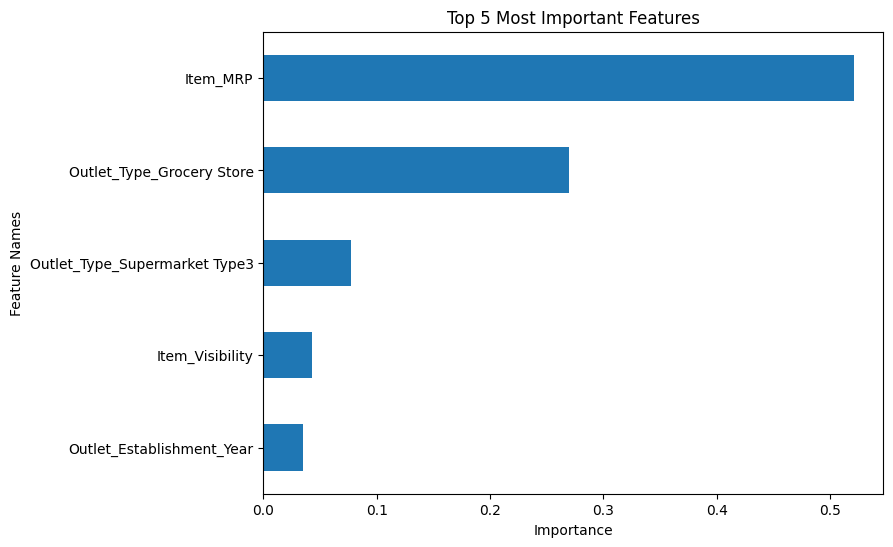

In [167]:
# Saving the feature importances of train/test data
importances = get_importances(reg, sort=True, ascending=False,
                              name='RandomForest Importances')
plot_importance(importances, top_n=5);

**Visually Inspect Features on Complete Dataset**

In [168]:
# Create a copy of whole dataset for visual inspection of features
plot_train = pd.concat([X_train_tf,y_train],axis=1)
plot_test = pd.concat([X_test_tf,y_test],axis=1)
plot_df = pd.concat([plot_train, plot_test])
# Inspect df to verify
plot_df

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
4776,0.83,-0.71,1.83,-0.80,1.33,1.08,0.75,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,515.33
7510,0.57,-1.29,0.60,-0.80,1.33,1.08,0.75,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,"3,056.02"
5828,-0.12,1.81,0.24,1.44,0.14,-1.38,0.75,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,"1,577.95"
5327,-1.16,-1.00,-0.95,0.43,0.73,-0.15,-0.26,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,"1,331.60"
4810,1.54,-0.97,-0.34,1.15,0.49,-0.15,-1.28,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,"1,687.14"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,1.12,-1.13,0.47,-1.16,-1.29,1.08,1.76,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,"3,793.73"
4836,-0.63,-1.29,0.02,-0.87,1.09,-0.15,-1.28,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,"2,410.86"
8064,-1.13,1.22,1.09,1.15,0.49,-0.15,-1.28,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,"5,309.76"
4418,-1.49,-0.78,-0.37,1.44,0.14,-1.38,0.75,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,"2,530.71"


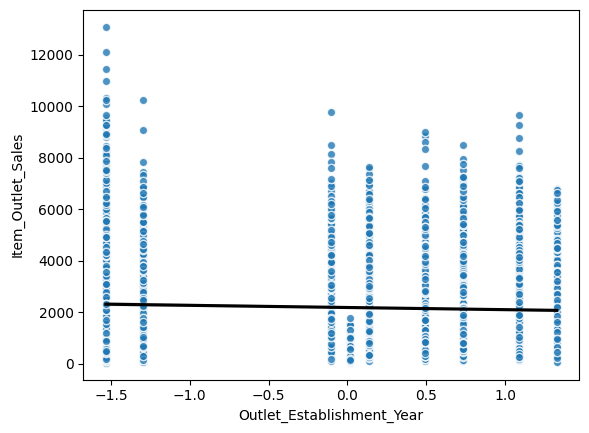

In [169]:
# Year of outlet establishment
sns.regplot(data=plot_df, x='Outlet_Establishment_Year',
            y='Item_Outlet_Sales',
            scatter_kws={'edgecolor':'white'},
            line_kws={'color':'black'});

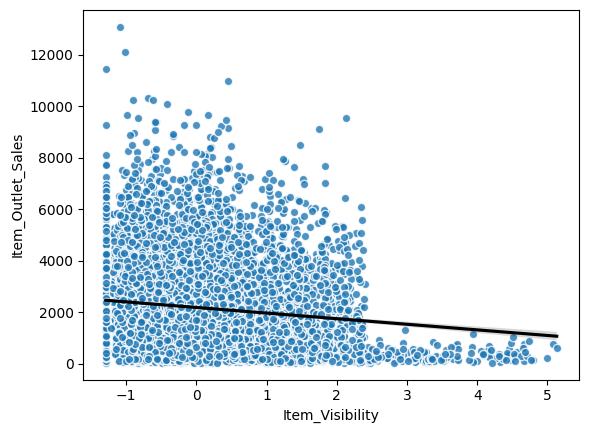

In [170]:
# Item visibility
sns.regplot(data=plot_df, x='Item_Visibility',
            y='Item_Outlet_Sales',
            scatter_kws={'edgecolor':'white'},
            line_kws={'color':'black'});

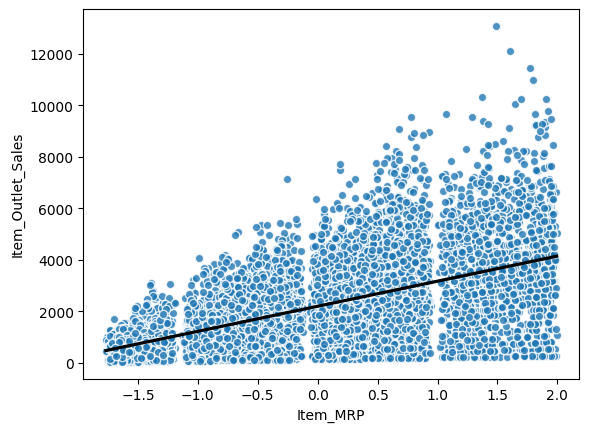

In [171]:
# Max retail price of item
sns.regplot(data=plot_df, x='Item_MRP',
            y='Item_Outlet_Sales',
            scatter_kws={'edgecolor':'white'},
            line_kws={'color':'black'});

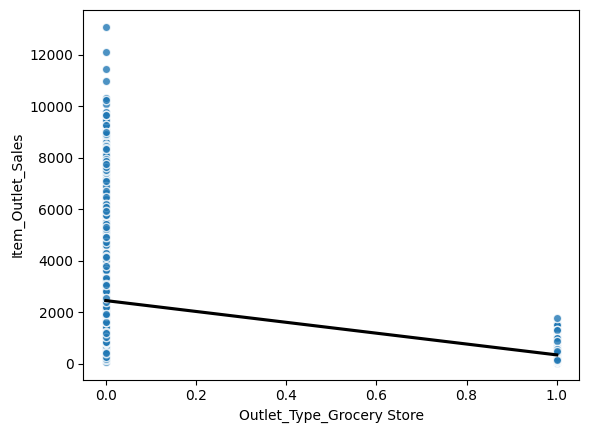

In [172]:
# Item sales location: Grocery Stores
sns.regplot(data=plot_df, x='Outlet_Type_Grocery Store',
            y='Item_Outlet_Sales',
            scatter_kws={'edgecolor':'white'},
            line_kws={'color':'black'});

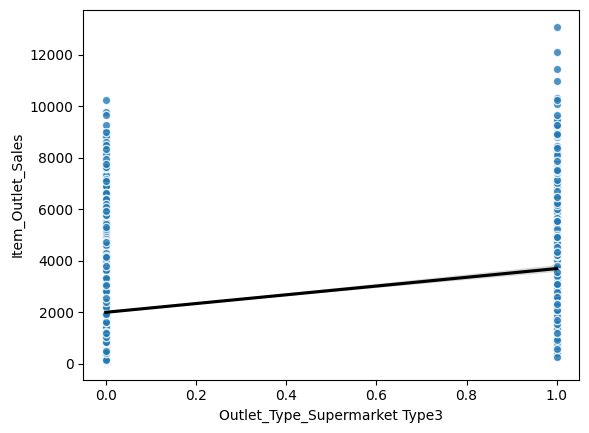

In [173]:
# Item sales location: Type 3 Supermarkets
sns.regplot(data=plot_df, x='Outlet_Type_Supermarket Type3',
            y='Item_Outlet_Sales',
            scatter_kws={'edgecolor':'white'},
            line_kws={'color':'black'});

## Linear Regression

Examine what features the Linear Regression Model used for it's prediction by visualizing and interpreting the model coefficients.

### Initial Examination

**Fit, transform, and get feature coefficients**

In [174]:
# Verify model fit to test data
lin_reg = LinearRegression()
lin_reg.fit(X_train_tf, y_train)
evaluate_regression(lin_reg, X_train_tf, y_train, X_test_tf, y_test)
# Obtain coefficients from linear regression model
lin_reg.coef_

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.474
- MSE = 1,297,939.721
- RMSE = 1,139.272
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 803.859
- MSE = 1,194,511.182
- RMSE = 1,092.937
- R^2 = 0.567


array([-7.86364457e+00, -2.11102926e+01,  9.84789254e+02, -4.46743125e+01,
        1.14884221e+02, -3.55947621e+01,  9.41592183e+01, -1.65016439e+14,
       -1.65016439e+14, -3.77846574e+14, -3.77846574e+14, -3.77846574e+14,
       -3.77846574e+14, -3.77846574e+14, -3.77846574e+14, -3.77846574e+14,
       -3.77846574e+14, -3.77846574e+14, -3.77846574e+14, -3.77846574e+14,
       -3.77846574e+14, -3.77846574e+14, -3.77846574e+14, -3.77846574e+14,
       -3.77846574e+14, -3.30785899e+15, -3.30785899e+15, -3.30785899e+15,
       -3.30785899e+15])

In [175]:
# Saving the coefficients as Pandas series including intercept
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs.loc['intercept'] = lin_reg.intercept_
# Display coefficients
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
coeffs

Item_Weight                                           -7.86
Item_Visibility                                      -21.11
Item_MRP                                             984.79
Outlet_Identifier                                    -44.67
Outlet_Establishment_Year                            114.88
Outlet_Location_Type                                 -35.59
Outlet_Size                                           94.16
Item_Fat_Content_Low Fat            -165,016,439,433,966.22
Item_Fat_Content_Regular            -165,016,439,433,903.75
Item_Type_Baking Goods              -377,846,574,247,041.44
Item_Type_Breads                    -377,846,574,247,069.00
Item_Type_Breakfast                 -377,846,574,246,995.69
Item_Type_Canned                    -377,846,574,247,012.25
Item_Type_Dairy                     -377,846,574,247,146.69
Item_Type_Frozen Foods              -377,846,574,247,043.56
Item_Type_Fruits and Vegetables     -377,846,574,246,994.94
Item_Type_Hard Drinks               -377

**Address Illogical Values caused by OHE**

Re-do the fitting and preprocessing with a new OHE encoder, addressing multicollinearity

In [176]:
# Make x and y variables
y = df['Item_Outlet_Sales']
X = df.drop(columns=['Item_Outlet_Sales'])
# train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [177]:
# Redefine the onehotencoder-add argument drop = 'first'
ohe_encoder = OneHotEncoder(drop = 'first', sparse=False)

# redefine pipeline with new onehoteoncder for categorical data
ohe_pipe = make_pipeline(impute_na, ohe_encoder)

# Redefine the tuple
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

# redefine preprocessor with updated ohe encoder
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], verbose_feature_names_out=False)

# fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Re-fitting and Examining After Implementing drop='first'

In [178]:
# fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 833.971
- MSE = 1,266,080.533
- RMSE = 1,125.202
- R^2 = 0.566

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 842.287
- MSE = 1,297,151.951
- RMSE = 1,138.926
- R^2 = 0.553


In [179]:
# Otain preprocessed feature names
lin_reg.feature_names_in_

array(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Location_Type',
       'Item_Fat_Content_Regular', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [180]:
# Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
coeffs['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                           6.84
Item_Visibility                     -10.81
Item_MRP                            972.81
Outlet_Identifier                   -37.12
Outlet_Establishment_Year            20.52
Outlet_Location_Type                -30.45
Item_Fat_Content_Regular             39.82
Item_Type_Breads                    -28.84
Item_Type_Breakfast                 -54.12
Item_Type_Canned                     -9.88
Item_Type_Dairy                    -110.12
Item_Type_Frozen Foods              -63.09
Item_Type_Fruits and Vegetables      14.66
Item_Type_Hard Drinks               -87.89
Item_Type_Health and Hygiene        -70.44
Item_Type_Household                 -55.88
Item_Type_Meat                      -23.18
Item_Type_Others                     -2.06
Item_Type_Seafood                    56.44
Item_Type_Snack Foods               -21.05
Item_Type_Soft Drinks              -147.11
Item_Type_Starchy Foods             -45.98
Outlet_Type_Supermarket Type1     1,966.28
Outlet_Type

These values are more in line with our item sales figures.

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 833.971
- MSE = 1,266,080.533
- RMSE = 1,125.202
- R^2 = 0.566

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 842.287
- MSE = 1,297,151.951
- RMSE = 1,138.926
- R^2 = 0.553


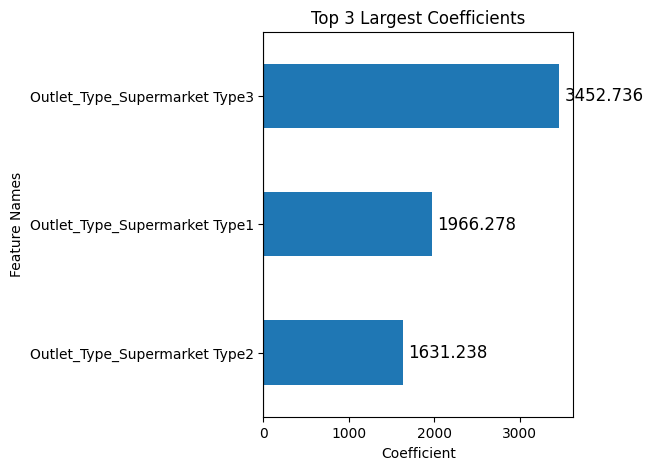

In [181]:
# Plot and examine the top three most impactful coefficients
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)
coeffs = get_coeffs_linreg(lin_reg)
plot_coeffs(coeffs, top_n=3, annotate=True);